# Using LSTMs to Predict LeBron James' Points in the Next Game

**Team:** Taiyo Nakai & Jonathan Wu  
**Objective:** Train an LSTM neural network to predict LeBron James' performance (e.g., over/under betting) using historical game data.  
**Methods:** LSTM model with softmax activation for multiclass outcomes. Incorporating long-term and short-term performance trends.  
**Data Source:** Basketball Reference (https://www.basketball-reference.com/players/j/jamesle01.html); CSV files for individual player game data  
**Evaluation:** Precision-based evaluation with every game betting simulation.  
**Experiments:** Hyperparameter tuning for LSTM architecture, dropout, and forget gate bias initialization.

## Imports and Purpose

- **`numpy` and `pandas`**: For numerical computations and data manipulation.
- **`os`**: Interact with the operating system (e.g., file paths).
- **`matplotlib.pyplot`**: Visualize data and results.
- **`tensorflow` and `keras`**: Build and train deep learning models.
- **`keras_tuner`**: Perform hyperparameter optimization.
- **`MinMaxScaler`**: Scale features to a normalized range [0, 1].
- **`train_test_split`**: Split dataset into training and testing sets.
- **`mean_squared_error`**: Evaluate model performance.
- **`sortedcontainers`**: Efficiently manage sorted collections (e.g., for unique, ordered sets) AND because we're using time series data, so it's important that our data is sorted.
- **LSTM**: Sequence modeling for temporal data.
- **Dense**: Fully connected layers for output and feature transformations.
- **Dropout**: Regularization techniques to prevent overfitting.
- **Bidirectional LSTM**: Capture dependencies in both forward and backward directions.
- **`l2` Regularizer**: Penalize large weights to reduce overfitting.

In [1359]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sortedcontainers import SortedSet
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2

# Loading and Merging LeBron James Game Logs

This code loads and combines multiple CSV files containing LeBron James' game logs from a specified folder.  
1. Recursively searches for CSV files in the `GAME_LOG_FOLDER`.  
2. Adds each file path to a sorted set to maintain the ordered date.  
3. Reads and concatenates all CSV files into a single DataFrame `df`.  


In [1360]:
GAME_LOG_FOLDER = "LeBron James Game Logs"

csv_files = SortedSet()
for dir_, _, files in os.walk(GAME_LOG_FOLDER):
    for file_name in files:
        rel_dir = os.path.relpath(dir_, GAME_LOG_FOLDER)
        rel_file = os.path.join(GAME_LOG_FOLDER, file_name)
        csv_files.add(rel_file)

df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,10/29/2003,18-303,CLE,@,SAC,L (-14),1,42:50:00,...,4,6,9,4,0,2,3,25,24.7,-9
1,2,2.0,10/30/2003,18-304,CLE,@,PHO,L (-9),1,40:21:00,...,10,12,8,1,0,7,1,21,14.7,-3
2,3,3.0,11/1/2003,18-306,CLE,@,POR,L (-19),1,39:10:00,...,4,4,6,2,0,2,3,8,5,-21
3,4,4.0,11/5/2003,18-310,CLE,NaN,DEN,L (-4),1,41:06:00,...,9,11,7,2,3,2,1,7,11.2,-3
4,5,5.0,11/7/2003,18-312,CLE,@,IND,L (-1),1,43:44:00,...,5,5,3,0,0,7,2,23,9,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,8,8.0,2024-11-06,39-312,LAL,@,MEM,L (-17),1,35:25,...,7,7,6,1,0,5,2,39,29.3,-21
1693,9,9.0,2024-11-08,39-314,LAL,NaN,PHI,W (+10),1,33:48,...,12,12,13,0,3,2,0,21,27.6,12
1694,10,10.0,2024-11-10,39-316,LAL,NaN,TOR,W (+20),1,34:47,...,8,10,16,1,0,3,0,19,24.6,13
1695,11,11.0,2024-11-13,39-319,LAL,NaN,MEM,W (+5),1,36:56,...,11,12,14,1,0,6,2,35,31.6,3


# Renaming Columns in Game Log Data

This code renames two in the game log DataFrame for better readability.  

1. Renames the columns `'Unnamed: 5'` and `'Unnamed: 7'` to `'Location'` and `'Score Differential'`, respectively.  


In [1361]:
df = df.rename(columns={'Unnamed: 5': 'Location', 'Unnamed: 7': 'Score Differential'})
df.columns.values

array(['Rk', 'G', 'Date', 'Age', 'Tm', 'Location', 'Opp',
       'Score Differential', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'GmSc', '+/-'], dtype=object)

# Data Cleaning & Feature Engineering

This code performs several data preprocessing steps on the game log DataFrame to clean.  
1. Drops rows where the `'G'` (Game) column is NaN.  
2. Converts the `'Date'` column to datetime format, and extracts the day, month, and year into new columns.  
3. Drops irrelevant columns like `'Rk'`, `'G'`, `'Date'`, etc.  
4. Maps categorical values in the `'Location'` column (home or away) and updates `'Opp'` and `'Tm'` columns to numeric values representing teams.  
5. Converts the `'MP'` column (minutes played) into a float, representing total minutes played in decimal format.  
6. Calculates and updates the `'Age'` column by converting it from a year-day format to a float representing age in years.  
7. Converts all columns to `float` type for consistency.  


In [1362]:
df.drop(df.index[df['G'].isnull()], inplace = True)

df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

df = df.drop(columns=['Rk', 'G', 'Date', 'Score Differential', 'GS', 'GmSc', '+/-', 'ORB', 'DRB', 'TRB', 
                      'AST', 'STL', 'BLK', 'TOV', 'PF'])

df['Location'] = df['Location'].map({'@': 1, np.nan: 0}) 

df['Opp'] = df['Opp'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                           'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                           'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                           'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                           'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                           'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31}) 

df['Tm'] = df['Tm'].map({'ATL': 1, 'BOS': 2, 'BRK': 3, 'NJN': 3, 'CHA': 4, 'CHO': 4,
                           'CHI': 5, 'CLE': 6, 'DAL': 7, 'DEN': 8, 'DET': 9, 'GSW': 10, 
                           'HOU': 11, 'IND': 12, 'LAC': 13, 'LAL': 14, 'MEM': 15, 'MIA': 16, 
                           'MIL': 17, 'MIN': 18, 'NOH': 19, 'NOK': 19, 'NOP': 19, 'NYK': 20, 
                           'OKC': 21, 'ORL': 22, 'PHI': 23, 'PHO': 24, 'POR': 25, 'SAC': 26,
                           'SAS': 27, 'SEA': 28, 'TOR': 29, 'UTA': 30, 'WAS': 31})

df['MP'] = df['MP'].apply(lambda x: round(int(x.split(':')[0]) + int(x.split(':')[1]) / 60, 2))

for i, row in df.iterrows():
    year, days = df.loc[i]['Age'].split('-')
    if int(df.loc[i]['Year']) % 4 == 0:
        days = int(days) / 366
    else:
        days = int(days) / 365
    df.loc[i, 'Age'] = int(year) + days

df = df.astype(float)
df

,Age,Tm,Location,Opp,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,PTS,Day,Month,Year
0,18.830137,6.0,1.0,26.0,42.83,12.0,20.0,0.600,0.0,2.0,0.000,1.0,3.0,0.333,25.0,29.0,10.0,2003.0
1,18.832877,6.0,1.0,24.0,40.35,8.0,17.0,0.471,1.0,5.0,0.200,4.0,7.0,0.571,21.0,30.0,10.0,2003.0
2,18.838356,6.0,1.0,25.0,39.17,3.0,12.0,0.250,0.0,1.0,0.000,2.0,2.0,1.000,8.0,1.0,11.0,2003.0
3,18.849315,6.0,0.0,8.0,41.10,3.0,11.0,0.273,0.0,2.0,0.000,1.0,1.0,1.000,7.0,5.0,11.0,2003.0
4,18.854795,6.0,1.0,12.0,43.73,8.0,18.0,0.444,1.0,2.0,0.500,6.0,7.0,0.857,23.0,7.0,11.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1692,39.852459,14.0,1.0,15.0,35.42,15.0,24.0,0.625,6.0,11.0,0.545,3.0,4.0,0.750,39.0,6.0,11.0,2024.0
1693,39.857923,14.0,0.0,23.0,33.80,9.0,14.0,0.643,2.0,4.0,0.500,1.0,1.0,1.000,21.0,8.0,11.0,2024.0
1694,39.863388,14.0,0.0,29.0,34.78,6.0,14.0,0.429,0.0,3.0,0.000,7.0,7.0,1.000,19.0,10.0,11.0,2024.0
1695,39.871585,14.0,0.0,15.0,36.93,13.0,22.0,0.591,4.0,7.0,0.571,5.0,8.0,0.625,35.0,13.0,11.0,2024.0


# Data Scaling and Splitting for Time-Series Model

This code scales the features and target variable, and prepares the data for training a time-series model using sliding windows.   
1. **Scaling:**  
   - Scales the feature columns (excluding `'PTS'`) using `MinMaxScaler`.  
   - Scales the target column `'PTS'` using the same scaler.  
2. **Data Splitting:**  
   - Defines a `split()` function that creates sequences of past data points (with a specified window length) to predict future values.  
3. **Train/Test Split:**  
   - Splits the scaled features into training (80%) and testing (20%) sets.  
4. **Windowing:**  
   - Applies the `split()` function to create input-output pairs for training and testing using a sliding window of length 10.  
5. **Reshaping:**  
   - Reshapes the input data into 3D arrays suitable for feeding into a neural network (samples, time steps, features).  
  

In [1363]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['PTS']))
scaled_target = scaler.fit_transform(df[['PTS']])

def split(dataset, window=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window), 0]
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    return np.array(dataX), np.array(dataY)

train_size = int(len(scaled_features) * 0.80)
test_size = len(scaled_target) - train_size
train, test = scaled_features[0:train_size,:], scaled_target[train_size:len(dataset),:]

window = 10
trainX, trainY = split(train, window)
testX, testY = split(test, window)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# For some reason there are NaNs even though there shouldn't be...
# This is just a hot-fix for now?
X_train = np.nan_to_num(trainX, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(trainY, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(testX, nan=0.0, posinf=0.0, neginf=0.0)
y_test = np.nan_to_num(testY, nan=0.0, posinf=0.0, neginf=0.0)

# Building and Training the LSTM Model

This code defines, compiles, and trains a LSTM model for predicting LeBron James' performance.  
1. **Model Architecture:**  
   - Creates a sequential model with the layers shown below
2. **Compilation:**  
   - Compiles the model using the Adam optimizer, mean squared error (MSE) loss, and mean absolute error (MAE) metric.  
3. **Callbacks:**  
   - Implements early stopping based on validation MAE with a patience of 10 epochs.  
4. **Training:**  
   - Trains the model for up to 100 epochs, using a batch size of 32, with validation data and the early stopping callback.  
5. **Output:** The model's training history is stored in `LSTM_History`.


In [1364]:
LSTM = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    LSTM(50,return_sequences=True),
    Dropout(0.2),
    LSTM(50,return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(48, kernel_regularizer=l2(0.001)),
    Dense(1, kernel_regularizer=l2(0.001), bias_initializer='zeros')
])

LSTM.compile(optimizer='adam', loss='mse', metrics=['mae'])

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
]

LSTM_History = LSTM.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.3907 - mae: 0.2783 - val_loss: 0.1442 - val_mae: 0.1053
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1458 - mae: 0.1849 - val_loss: 0.0675 - val_mae: 0.1105
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0796 - mae: 0.1693 - val_loss: 0.0447 - val_mae: 0.1033
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0287 - mae: 0.0469 - val_loss: 0.0344 - val_mae: 0.1052
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - mae: 0.0334 - val_loss: 0.0296 - val_mae: 0.1057
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - mae: 0.0319 - val_loss: 0.0263 - val_mae: 0.1048
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - mae: 0.0279 - val_loss: 0.0247 - val_mae: 0.1062
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0087 - mae: 0.0290 - val_loss: 0.0230 - val_mae: 0.1048
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.00

# Evaluating and Making Predictions with the LSTM Model

This code evaluates the trained LSTM model on the test set and makes predictions on LeBron James.  
1. **Model Evaluation:**  
   - Evaluates the model on the test set using the `evaluate()` method.
2. **Prediction:**  
   - Uses the model's `predict()` method to generate predictions on the test set (`X_test`).  
   - Inverse scales the predictions using the `scaler.inverse_transform()` to convert them back to the original scale of the target variable.  
   - Rounds the predictions to the nearest integer to represent the predicted points.  
3. **Rescaling y_test:**  
   - Inverse scales the actual test targets (`y_test`) back to the original scale for comparison.


In [1365]:
loss, mae = LSTM.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")
predictions = LSTM.predict(X_test)
predictions = scaler.inverse_transform(predictions)
predictions = [round(points[0]) for points in predictions]
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0191 - mae: 0.1023 
Test Loss: 0.020219359546899796, Test MAE: 0.10429485887289047
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


# Plotting Actual vs. Predicted Values

This code visualizes the actual and predicted values of points scored for the test set.


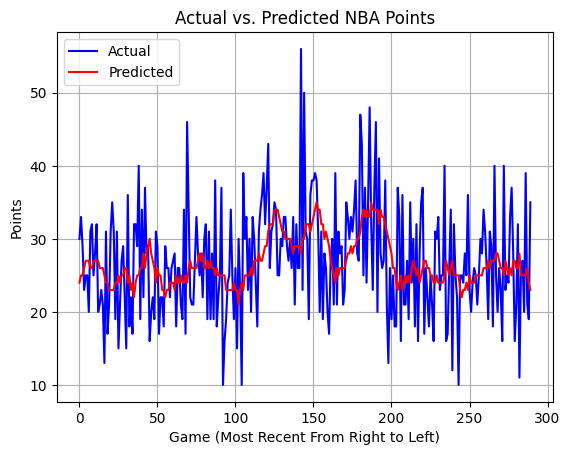

In [1366]:
plt.plot(y_test, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')

plt.title('Actual vs. Predicted NBA Points')
plt.xlabel('Game (Most Recent From Right to Left)')
plt.ylabel('Points')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

# To Do

1. Incorporate predicting in the future (how?)
2. Develop another experiment to test if that LSTM model will work better
3. Verify with a betting site on LeBron James
4. Bet $100 a day for each betting line
5. Calculate our wins/losses before the project deadline
6. ??? Probably other stuff I'm missing

# Hyperparameter Tuning for LSTM Model (WIP, may not be actually needed)

This code demonstrates tuning the hyperparameters of an LSTM-based model for predicting LeBron James' points in future games.


In [1367]:
# # Define the model-building function
# def build_model(hp):
#     model = Sequential()
#     model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    
#     # First LSTM layer with tunable units
#     model.add(Bidirectional(LSTM(units=hp.Int('lstm_units_1', min_value=32, max_value=128, step=32), 
#                    return_sequences=True, kernel_regularizer=l2(0.001))))
    
#     # Second LSTM layer with tunable units
#     model.add(LSTM(units=hp.Int('lstm_units_2', min_value=16, max_value=64, step=16), 
#                    return_sequences=True, kernel_regularizer=l2(0.001)))
    
#     # Third LSTM layer
#     model.add(LSTM(units=hp.Int('lstm_units_3', min_value=16, max_value=32, step=16), 
#                    kernel_regularizer=l2(0.001)))
    
#     # Tunable dropout rate
#     model.add(Dropout(rate=hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    
#     # Dense layer with tunable neurons
#     model.add(Dense(units=hp.Int('dense_units', min_value=16, max_value=64, step=16)))
    
#     # Final output layer
#     model.add(Dense(1, kernel_regularizer=l2(0.001)))
    
#     # Compile the model with tunable learning rate
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
#         loss='mse',
#         metrics=['mae']
#     )
    
#     return model

# # Initialize the tuner
# tuner = kt.Hyperband(
#     build_model,  # Model-building function
#     objective='val_mae',  # Optimize for validation MAE
#     max_epochs=50,  # Max epochs for training
#     factor=3,  # Reduction factor
# )

# # Perform hyperparameter search
# tuner.search(
#     X_train, y_train,
#     epochs=50,
#     validation_data=(X_test, y_test),
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)  # Prevent overfitting
#     ]
# )

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The optimal number of units in the first LSTM layer is {best_hps.get('lstm_units_1')},
# the second LSTM layer is {best_hps.get('lstm_units_2')},
# the dropout rate is {best_hps.get('dropout')},
# the dense layer has {best_hps.get('dense_units')} units,
# and the optimal learning rate is {best_hps.get('learning_rate')}.
# """)

# # Build the best model
# model = tuner.hypermodel.build(best_hps)

# callbacks = [
#     keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)
# ]

# # Train the best model
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=64,
#     validation_data=(X_test, y_test),
#     callbacks=callbacks
# )